<a href="https://colab.research.google.com/github/khangdltUIT/Deep_Learning/blob/main/efficientnet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Efficientnet: Rethinking model scaling for convolutional Neural Network**


## *Introduction*


Efficientnet was proposed at paper: *Efficientnet: Rethinking model scaling for convolutional Neural Network* by researchers at Google Brain. In that paper, reseachers proposed a compound scaling method which scale up not only depth dimension but also width and resoluton dimensions.

* Depth: simply means how deep the networks is which is equivalent to the number of layers in it
* Width: simply means how wide the network is 
* Resolution: is simply the image resolution that is being passed to a CNN

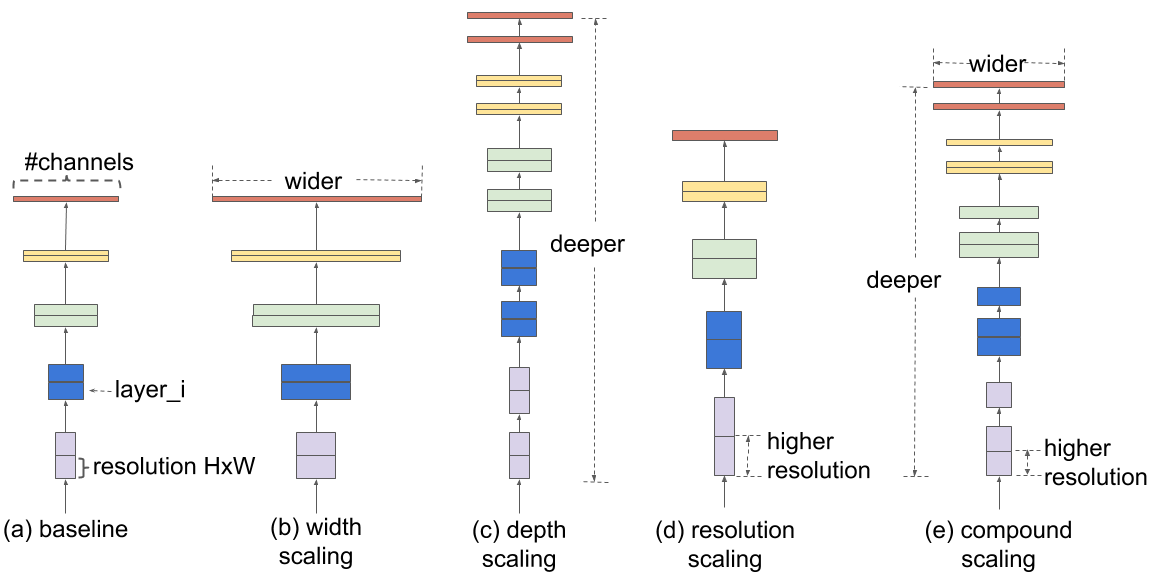

## **Implementation**

In this section, I will use Pytorch frameword for implementaion Efficientnet.  
Regarding the dataset, I use Dog/Cat Classification publshing on kaggle.com

### Step 01: Set up environment


##### Check GPU Info

In [ ]:
!nvidia-smi

Thu Mar 25 01:35:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Import Libraries used in this project

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import roc_auc_score
import re
import albumentations as albu
from albumentations.pytorch import ToTensor
import re
import albumentations as albu
from albumentations.pytorch import ToTensor

print('Importing... done!')

Importing... done!


### Step 02: CORONA CHEST DATASET

* Information:  
The utility of this dataset has been confirmed by a senior radiologist in Tongji Hospital, Wuhan, China, who has performed diagnosis and treatment of a large number of COVID-19 patients during the outbreak of this disease between January and April.

In [ ]:
!git clone https://github.com/UCSD-AI4H/COVID-CT

Cloning into 'COVID-CT'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 43.11 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


In [ ]:
!unzip -q '/content/COVID-CT/Images-processed/CT_COVID.zip'

In [ ]:
!unzip -q '/content/COVID-CT/Images-processed/CT_NonCOVID.zip'

In [ ]:
!mkdir Image

In [ ]:
!mv '/content/CT_COVID' '/content/Image'

In [ ]:
!mv '/content/CT_NonCOVID' '/content/Image'

### Step 03: Define Data Loader

In [ ]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [ ]:
class CovidCTDataset():
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [ ]:

trainset = CovidCTDataset(root_dir='/content/Image',
                            txt_COVID='/content/COVID-CT/Data-split/COVID/trainCT_COVID.txt',
                            txt_NonCOVID='/content/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                            transform= train_transformer)
valset = CovidCTDataset(root_dir='/content/Image',
                            txt_COVID='/content/COVID-CT/Data-split/COVID/valCT_COVID.txt',
                            txt_NonCOVID='/content/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
                            transform= val_transformer)
testset = CovidCTDataset(root_dir='/content/Image',
                            txt_COVID='/content/COVID-CT/Data-split/COVID/testCT_COVID.txt',
                            txt_NonCOVID='/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
                            transform= val_transformer)
print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

batchsize = 8

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

425
118
203


In [ ]:
def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#            data = data[:, 0, :, :]
#            data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
          
    return targetlist, scorelist, predlist


In [ ]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#            data = data[:, 0, :, :]
#            data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    

In [ ]:
alpha = None
device = 'cuda'
def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#       
        
        optimizer.zero_grad()
        output = model(data)
        
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)
        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    
    f = open('modelb7_result/{}.txt'.format(modelname), 'a+')
    f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    f.write('\n')
    f.close()
    
    return train_loss/len(train_loader.dataset)



# In[152]:




### Step 04: Install Efficientnet backbone

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=365a5a3e2ef26b30e277a06a40f62f8c27d1c07a662b25b2a7270cb3e0e6c247
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
!mkdir modelb7_result
!mkdir train_10epochs_model_backup

mkdir: cannot create directory ‘train_10epochs_model_backup’: File exists


In [ ]:
### efficientNet
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=2)
model = model.cuda()
modelname = 'efficientNet-b7'

bs = 10
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#scheduler = StepLR(optimizer, step_size=1)

total_epoch = 40
cur_loss = 1000
for epoch in range(1, total_epoch+1):
    train_loss = train(optimizer, epoch)

    #if (cur_loss < train_loss) and ((cur_loss - train_loss) < 0.000001):
    #    break
    #else:
    #    cur_loss = train_loss

    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "train_10epochs_model_backup/{}.pth".format(modelname))  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        f = open('/content/modelb7_result/{}.txt'.format(modelname), 'a+')
        f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))
        f.close()


# In[145]:



    

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7
Train Epoch: 1 [0/54 (0%)]	Train Loss: 0.070402
Train Epoch: 1 [10/54 (19%)]	Train Loss: 0.067073
Train Epoch: 1 [20/54 (37%)]	Train Loss: 0.075941
Train Epoch: 1 [30/54 (56%)]	Train Loss: 0.061829
Train Epoch: 1 [40/54 (74%)]	Train Loss: 0.041016
Train Epoch: 1 [50/54 (93%)]	Train Loss: 0.047014

Train set: Average loss: 0.0767, Accuracy: 287/425 (68%)

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.49373552 0.55393398 0.63021719 0.63362116 0.4489952  0.58370119
 0.68258911 0.66679639 0.54642129 0.38953    0.5763191  0.29776391
 0.52135319 0.51685613 0.50404251 0.53674889 0.40945753 0.5162518
 0.53720677 0.43842733 

In [ ]:

# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 10
for epoch in range(1, total_epoch+1):
    
    targetlist, scorelist, predlist = test(epoch)
#     print('target',targetlist)
#     print('score',scorelist)
#     print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 
    
    TP = ((predlist == 1) & (targetlist == 1)).sum()
    TN = ((predlist == 0) & (targetlist == 0)).sum()
    FN = ((predlist == 0) & (targetlist == 1)).sum()
    FP = ((predlist == 1) & (targetlist == 0)).sum()

    print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
    print('TP+FP',TP+FP)
    p = TP / (TP + FP)
    print('precision',p)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    print('recall',r)
    F1 = 2 * r * p / (r + p)
    acc = (TP + TN) / (TP + TN + FP + FN)
    print('F1',F1)
    print('acc',acc)
    AUC = roc_auc_score(targetlist, vote_score)
    print('AUC', AUC)

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        
#         print('vote_pred', vote_pred)
#         print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUC', AUC)
        
        
#         f = open('model_result/{modelname}.txt', 'a+')
#         f.write('precision, recall, F1, acc= \n')
#         f.writelines(str(p))
#         f.writelines('\n')
#         f.writelines(str(r))
#         f.writelines('\n')
#         f.writelines(str(F1))
#         f.writelines('\n')
#         f.writelines(str(acc))
#         f.writelines('\n')
#         f.close()
        
        
        vote_pred = np.zeros((1,testset.__len__()))
        vote_score = np.zeros(testset.__len__())
        print('vote_pred',vote_pred)
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        f = open(f'modelb7_result/test_{modelname}.txt', 'a+')
        f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))
        f.close()

TP= 90 TN= 76 FN= 15 FP= 22
TP+FP 112
precision 0.8035714285714286
recall 0.8571428571428571
F1 0.8294930875576038
acc 0.8177339901477833
AUC 0.8761904761904762
TP= 90 TN= 76 FN= 15 FP= 22
TP+FP 112
precision 0.8035714285714286
recall 0.8571428571428571
F1 0.8294930875576038
acc 0.8177339901477833
AUC 0.8761904761904762
TP= 90 TN= 76 FN= 15 FP= 22
TP+FP 112
precision 0.8035714285714286
recall 0.8571428571428571
F1 0.8294930875576038
acc 0.8177339901477833
AUC 0.8761904761904762
TP= 90 TN= 76 FN= 15 FP= 22
TP+FP 112
precision 0.8035714285714286
recall 0.8571428571428571
F1 0.8294930875576038
acc 0.8177339901477833
AUC 0.8761904761904762
TP= 90 TN= 76 FN= 15 FP= 22
TP+FP 112
precision 0.8035714285714286
recall 0.8571428571428571
F1 0.8294930875576038
acc 0.8177339901477833
AUC 0.8761904761904762
TP= 90 TN= 76 FN= 15 FP= 22
TP+FP 112
precision 0.8035714285714286
recall 0.8571428571428571
F1 0.8294930875576038
acc 0.8177339901477833
AUC 0.8761904761904762
TP= 90 TN= 76 FN= 15 FP= 22
TP+FP 

### Step 05: Save result and file pth

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp '/content/train_10epochs_model_backup/efficientNet-b7.pth' '/content/drive/MyDrive/REPORT/Research/EfficientNet/model_efficientNet-b7.pth'

In [ ]:
%cp '/content/modelb7_result/efficientNet-b7.txt' '/content/drive/MyDrive/REPORT/Research/EfficientNet/result_b7.txt'

### Predicted 